# Lecture 10: Classification - 1

COMP 3921F \
Applied Machine Learning \
Mon 4:40 PM - 5:55 PM \
Tue: 5:00 PM - 6:15 PM

Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Feb xx, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 2 and 3 still open for submission.
2. Recitation will review Scikit-learn API and usage.
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.



# Classification  


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-10/classification-creative.png" />      
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>

 
In previous lectures, we have  studied classification using the Decision Tree and the Perceptron algorithm respectively.  

Those algorithms are fundamental to understanding Machine Learning but in the next several lectures we will consider many sophisticated algorithms that represent the state-of-the-art in model structure and parameterization, training methodology (especially for large datasets), and prediction quality.  

The new algorithms are widely used in emerging application domains (including text, images, video, speech, and multi-modal data applications).  

The lecture will also being to define several model metrics that are widely used for the assessing the quality of classification models.

</td></table> 


# MNIST Handwritten digits classification

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits


Let us start by a quick demo of a different type of classifier, we will use here a version of  the famous MNIST dataset of handwritten digits.

This dataset consists of handwritten relatively low-resolution images (8x8 pixels) of handwritten digits (0-9).

Our task is to use the labeled examples to build a classification model that can predict the digit for unlabeled images.    This is a multi-label classification problem.  

Lets load the data and take a look at a few examples.

In [2]:
import numpy as np
bunch = load_digits()
print(f"data shape: {bunch['data'].shape}")
print(bunch.DESCR)


data shape: (1797, 64)
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels 

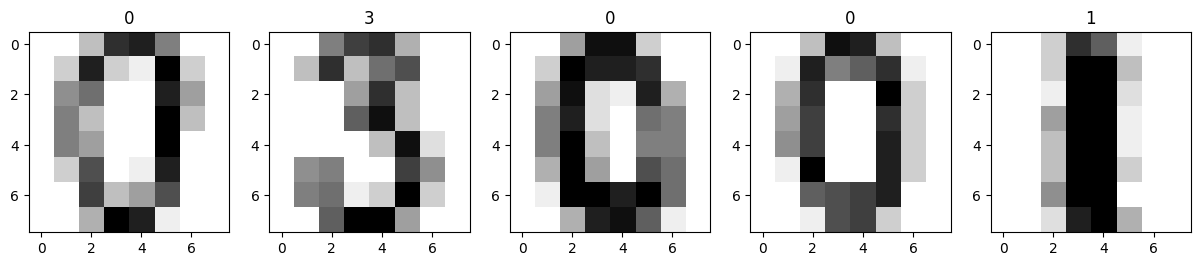

In [3]:
nobs = bunch['data'].shape[0]
nplots = 5
choices = np.random.choice(np.arange(nobs), size=nplots)
fig, ax = plt.subplots(1, nplots, figsize=(15, 5))
for i, idx in enumerate(choices):
    ax[i].imshow(bunch['images'][idx], interpolation='nearest', cmap=plt.cm.gray_r)
    ax[i].set_title(bunch['target'][idx])

We use as features is the individual "gray scale" pixel values of the array unrolled or "raveled" such that they are a single vector.  

Therefore, since each image is 8x8 , this means we will have a feature vector of 64 features. 

In summary, this is   no different from the other applications with supervised learning applications involving tabular data that we have seen to this point. 


In [4]:
bunch['data'].max(), bunch['data'].mean(), bunch['data'].min()

(16.0, 4.884164579855314, 0.0)


Next,  lets create our normal dataset splits so we can train a model and evaluate the performance.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bunch['data'], bunch['target'])

For now, before we learn the underlying details, let us try out the  `LogisticRegression` modeling algorithm in Scikit, which is specifically intended for 2-label or multi-label classification problems (such as the MNIST classification problem). 


In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
pred = lr.predict(X_test)

Pick a few random test examples and look at the predictions

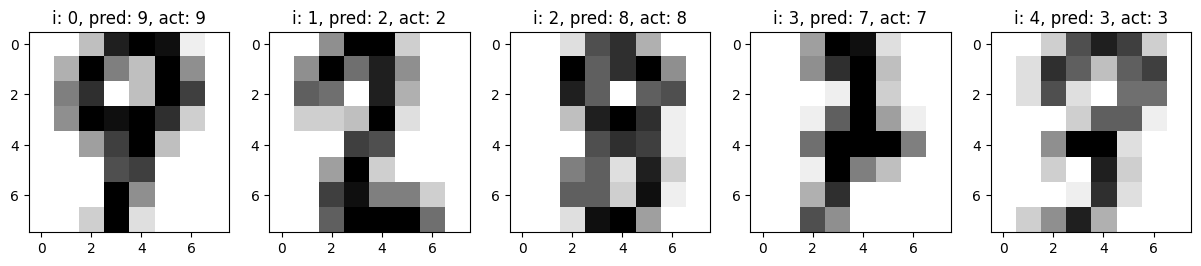

In [7]:
nobs = X_test.shape[0]
nplots = 5
choices = np.random.choice(np.arange(nobs), size=nplots)
fig, ax = plt.subplots(1, nplots, figsize=(15, 5))
for i, idx in enumerate(choices):
    ax[i].imshow(X_test[i].reshape(8, 8), interpolation='nearest', cmap=plt.cm.gray_r)
    ax[i].set_title(f'i: {i}, pred: {pred[i]}, act: {y_test[i]}')


In order to see how we did, we can create a "confusion matrix".  This is a matrix which plots the true label against the predicted label and allows us to see not only how well our predictions are working, but also, where exactly we are going wrong.

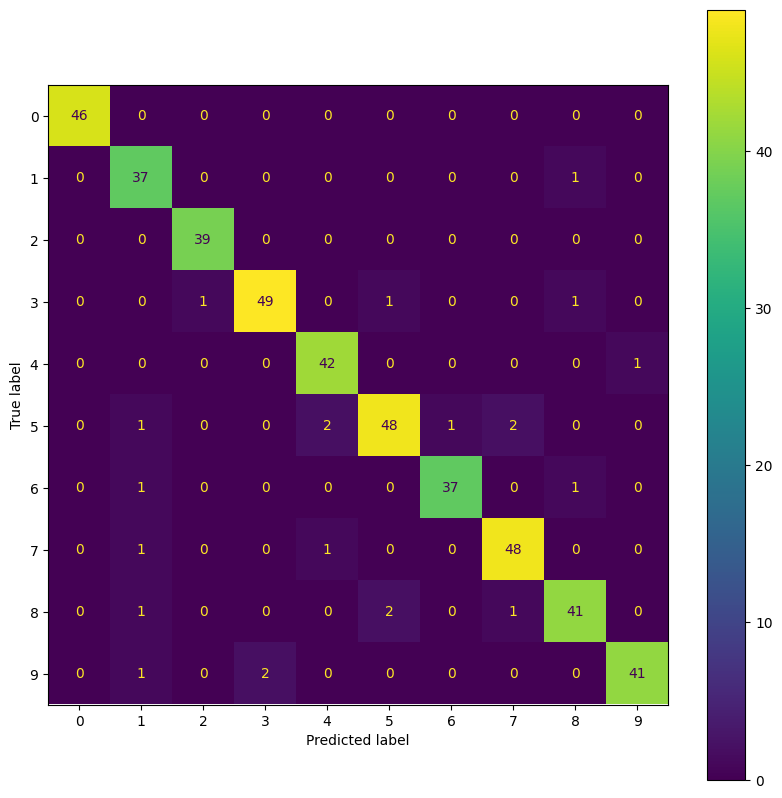

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred)).plot(ax=ax)
plt.show()

At this point we have fit a classifier on a multi-class classification problem.  

This was quite straightforward using scikit-learn, but we now describe the underlying theory of the logistic regression algorithm, starting with the simplest case of Binary Classifiers.

# Binary Classifiers

 Remember our Linear Regression model?  We would like to extend this to do binary classification (and  multi-class classification eventually).  

This extension is called the logistic regression model (or sometimes logit) which is one of the simpler linear models which does classification.  Like a linear regression it has the desirable properties of interpretability and ease of training, however, unlike the linear regression it predicts the probability of an output as opposed to the output itself.  We do this by adding a non-linear function (in this case the sigmoid function) to the functional form.


# The Logistic Regression Model

Let the feature vector and model parameters be denoted by $x = [x_0, x_1, \ldots, x_d]$ and $\theta = [\theta_0, \theta_1, \ldots, \theta_d] $ respectively.  

The logistic regression model is given by:

$$ f(x; \theta) = \sigma(\theta^T x) = \frac{1}{1 + \exp(-\theta^T x)}, $$

where
$$ \sigma(z) = \frac{1}{1 + \exp(-z)} $$
is known as the  *logistic* or *sigmoid*  function.

The logistic/sigmoid function $\sigma : \mathbb{R} \to [0,1]$ maps the points on the real line  to  $[0,1]$ (which is the scale on which probability is measured.

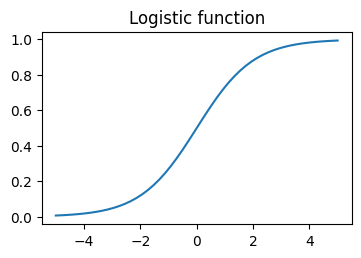

In [27]:
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-5, 5)
plt.figure(figsize=(4,2.5))
plt.plot(z, sigmoid(z))
plt.title("Logistic function")
plt.show()

# The Logistic Function: Properties


A few observations:

* $\sigma(z)$ tends to 1 as $z \to \infty$ and tends to 0 as $z \to -\infty$.



* Analytic derivatives are available for $\sigma(z)$  in the form:
$d\sigma/dz = \sigma(z)(1-\sigma(z)).$

* Thus,  the function $\sigma(\theta^T x)$ leads to  outputs that take values between 0 and 1, which is suitable as a probability scale for binary outcomes.

* We can threshold the logistic output (say at 0.5) to obtain a classification based on the predicted probability.

Let's implement our model using the sigmoid function.

In [28]:
def f(X, theta):
    """The sigmoid model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return sigmoid(X.dot(theta))

# Review: Maximum Log- Likelihood 

The  likelihood maximization principle is given by
$$ \max_\theta \mathbb{E}_{x, y \sim \mathbb{P}_\text{data}} \log P_\theta(y|x; \theta). $$

Maximizing the likelihood is equivalent to maximizing the log-likelihood, and both functions have identical optima.  Why?

Further, instead of maximizing the log-loglikelihood we minimize the negative log-likelihood.  The parameter estimation using minimum negative log-likelihood is then equivalent to our earlier approach using "loss functions", e.g. $l_2$ norm used for linear regression.  In fact, with the right probability model for model fit residuals, the earlier approaches are essentially equivalent to minimum negative log-likelihood. 

# Probabilistic motivation for Least Squares Regression

A linear model $y = \theta^T x$ can be fitted using least squares.  This approach can be interpreted in terms of a Gaussian probability distribution for the targe with mean $\mu = \theta^T x$ and standard deviation $\sigma$. 
$$ p(y | x; \theta) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y - \theta^T x)^2}{2 \sigma^2} \right).$$

The negative log-likelihood (or log-probability) denoted $L(\theta)$ for any  $(x,y)$ is given by 
\begin{align*}
\log L(\theta) = \log p(y | x; \theta) = \frac{1}{2\sigma^2} \cdot (y - \theta^T x)^2 + \log {\sqrt{2\pi}\sigma}.
\end{align*}

If $\sigma$ is some (unknown) constant, the  the minimization is equivalent to the linear Least Squares regression (i.e. using a $l_2$ norm loss function).  is thus equivalent to fitting the Gaussian model of the form $\mathcal{N}(y; \mu(x), \sigma)$ with a constant standard deviation $\sigma$  and a mean of $\mu(x) = \theta^T x$.

# Probabilistic Approach to Binary Classification

Similarly, we can take a probabilistic perspective to obtain an algorithm for binary classification using logistic regression.

We will start by using our logistic model to parametrize a probability distribution as follows:
\begin{align*}
p(y=1 | x;\theta) & = \sigma(\theta^T x) \\
p(y=0 | x;\theta) & = 1-\sigma(\theta^T x).
\end{align*}
A probability $y\in \{0,1\}$ of the form $P(y=1) = p$ is called Bernoulli.

Note that we can write this more compactly as
\begin{align*}
p(y | x;\theta) = \sigma(\theta^T x)^y \cdot (1-\sigma(\theta^T x))^{1-y}
\end{align*}

#  Maximum Lilkelihood and Linear Regression

Following the principle of maximum likelihood, we want to optimize the following objective defined over a training dataset  $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.
\begin{align*}
L(\theta) & = \prod_{i=1}^n p(y^{(i)} \mid x^{(i)} ; \theta) \\
& = \prod_{i=1}^n \sigma(\theta^T x^{(i)})^{y^{(i)}} \cdot (1-\sigma(\theta^T x^{(i)}))^{1-y^{(i)}}.
\end{align*}

This log of this objective is also often called the log-loss, or cross-entropy.

This model and objective function define *logistic regression*, one of the most widely used classification algorithms.

Let's implement the likelihood objective.

In [29]:
def log_likelihood(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    We added the 1e-6 term in order to avoid overflow (inf and -inf).
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return (y*np.log(f(X, theta) + 1e-6) + (1-y)*np.log(1-f(X, theta) + 1e-6)).mean()

# Review: Gradient Descent
If we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). $$

As code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```

# Derivatives of the Log-Likelihood

Let's work out the gradient for our log likelihood objective:

\begin{align*}
& \frac{\partial \log L(\theta)}{\partial \theta_j} = 
\frac{\partial}{\partial \theta_j} \log \left[ \sigma(\theta^T x)^{y} \cdot (1-\sigma(\theta^T x))^{1-y} \right] \\
& = \left( y\cdot \frac{1}{\sigma(\theta^T x)} - (1-y) \frac{1}{1-\sigma(\theta^\top x)} \right)  \frac{\partial}{\partial \theta_j} \sigma(\theta^T x) \\
& = \left( y\cdot \frac{1}{\sigma(\theta^T x)} - (1-y) \frac{1}{1-\sigma(\theta^T x)} \right)  \sigma(\theta^T x) (1-\sigma(\theta^T x)) \frac{\partial}{\partial \theta_j} \theta^T x \\
& = \left( y\cdot (1-\sigma(\theta^T x)) - (1-y) \sigma(\theta^T x) \right) x_j \\
& = \left( y - f(x; \theta) \right) x_j.
\end{align*}

# Gradient of the Log-Likelihood

Using the above expression, we obtain the following gradient:
\begin{align*}
\nabla_\theta J (\theta) = 
\left( y - f(x; \theta) \right) \cdot \bf{x}.
\end{align*}
* This expression looks very similar to the gradient of the mean squared error.
* However, it is different, because the model $f_\theta$ is different.

Let's implement the gradient.

In [32]:
def loglik_gradient(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    return np.mean((y - f(X, theta)) * X.T, axis=1)

# Gradient Descent for Logistic Regression

Putting this together, we obtain a complete learning algorithm, logistic regression.


```python
theta, theta_prev = random_initialization()
while abs(J(theta) - J(theta_prev)) > conv_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * (f(x, theta)-y) * x
```

Let's implement this algorithm.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((426, 30), (143, 30))

In [3]:
print(load_breast_cancer()['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Lets train our Logistic Regression on this dataset.  Like a Linear Regression we use numerical optimization methods to find the best parameters for the model as we do not in general have a closed form solution.  



In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)


Now we can compute the `accuracy` of the model, which is simply the number of predictions that were correct divided by the total number of predictions.  

We can compute this metric 3 different ways with the same result, one explicitly, two, using the scikit learn (default) score method or using the sklearn.metrics score function. 

In [6]:

print((lr.predict(X_test) == y_test).sum() / y_test.shape[0])

print(lr.score(X_test, y_test))

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, lr.predict(X_test)))

0.972027972027972
0.972027972027972
0.972027972027972


We can use the model to predict the output class

In [7]:
lr.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0])

Or we can use the model to predict the output probabilities and threshold the values to obtain the respective class probabilities

In [8]:
[f"{i[0]:.3f}, {i[1]:.3f}" for i in lr.predict_proba(X_test[:10])]

['0.000, 1.000',
 '0.001, 0.999',
 '1.000, 0.000',
 '0.005, 0.995',
 '0.463, 0.537',
 '0.000, 1.000',
 '0.052, 0.948',
 '0.040, 0.960',
 '0.147, 0.853',
 '0.010, 0.990']

The distribution of the predicted probabilities can be examined using a histogram. 

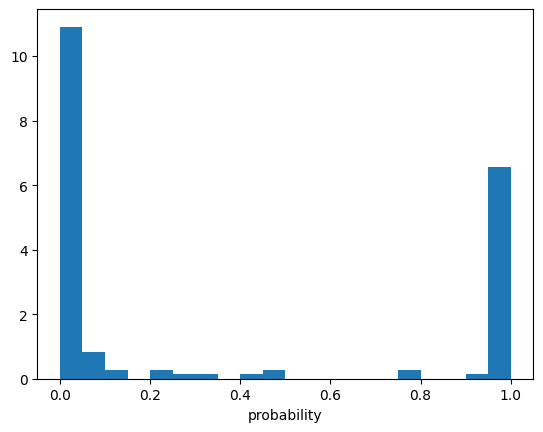

In [10]:
import matplotlib.pyplot as plt
plt.hist(lr.predict_proba(X_test)[:, 0], bins=20, density=True);
plt.xlabel('probability');

We can see that the majority of the probabilites are very close to either 0 or 1 in which case the classifier is fairly sure about the correct class for those examples. However, there are some examples where the classifier is not quite as sure. This means that to actually apply a lable on those examples, we need to define a threshold.

Lets explore what happens as we vary the threshold.

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from ipywidgets import interact, FloatSlider
@interact
def plot_diff(threshold=FloatSlider(min=0.001, max=.999, step=.1, value=.5)):
    pred = (lr.predict_proba(X_test)[:, 1] > threshold).astype(int)
    fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred)).plot();
    plt.title(f"Accuracy= {accuracy_score(y_test, pred):.3f}")
    plt.show()

plot_diff;

interactive(children=(FloatSlider(value=0.5, description='threshold', max=0.999, min=0.001), Output()), _dom_c…

We can more rigoursly plot this by plotting the accuracy as a function of the threshold that we set.

Text(0, 0.5, 'accuracy')

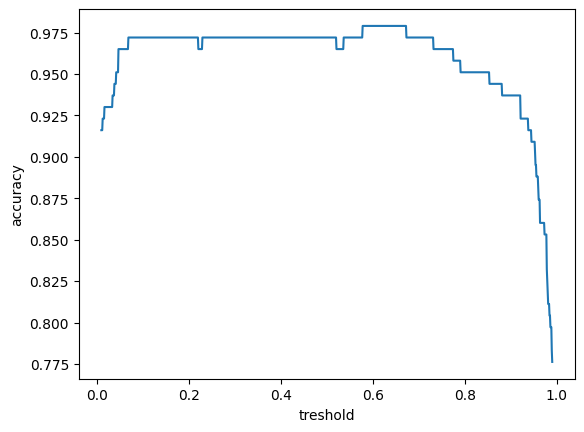

In [14]:
import numpy as np
thresholds = np.linspace(.01, .99, 1000)
probas = lr.predict_proba(X_test)[:, 1]
accuracies =  [accuracy_score(y_test, (probas > threshold).astype(int))
               for threshold in thresholds]
plt.plot(thresholds, accuracies);
plt.xlabel('treshold')
plt.ylabel('accuracy')

# Summary: Logistic Regression

* Logistic regression finds a linear decision boundary, is the set of points for which $P(y=1|x)=P(y=0|x)$, or equivalently:
\begin{align*}
0 = \log\frac{P(y=1|x)}{P(y=0|x)}
= \log \frac{\sigma(\theta^T x)}{1-\sigma(\theta^T x)}
= \theta^T x
\end{align*}
The claim holds because $0=\theta^\top x$ is a linear function.

* Unlike least squares, we don't have a closed form solution for $\theta$, but we can still apply gradient descent.